In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from timeit import default_timer as timer


In [ ]:
def evalf(x):
  a1 = (x[0]-x**2)**2 + (x - 1)**2  
  return sum(a1)

def evalg(x):
  grad = [2*(i-1) - 4*(x[0] - i**2)*i for i in x]
  grad[0] = -2 + 4*x[0] -6*x[0]**2 +4*x[0]**3 + sum([2*(x[0]-i**2) for i in x[1:]])

  return np.array(grad,dtype='float64')

def evalh(x):
  dder = [2-4*x[0]+12*i**2 for i in x]
  dder[0] =  - 12*x[0] + 12*x[0]**2 +2*(len(x)+1)
  hes = np.diagflat(dder)
  crs = [-4*i for i in x[1:]]
  hes[0][1:] = crs
  hes[1:,0] = crs
  return hes

def compute_B_k(B,sk,yk):
  yk = yk.reshape(-1,1)
  sk = sk.reshape(-1,1)
  mk = 1/(yk.T@sk)
  I = np.eye(len(B))
  return (I - mk*sk@yk.T)@B@(I - mk*yk@sk.T) + mk*sk@sk.T

In [ ]:
def compute_steplength_backtracking_scaled_direction(x, gradf, p, alpha_start, rho=0.5, gamma=0.5): #add appropriate arguments to the function 
  assert type(x) is np.ndarray  
  assert type(gradf) is np.ndarray 
  assert type(p) is np.ndarray 
  assert alpha_start>=0.
  assert type(rho) is float and rho>=0
  assert type(gamma) is float and gamma>=0

  alp = alpha_start
  x = np.array(x,dtype='float64')
  while evalf(x + np.multiply(alp,p)) > evalf(x) + gamma*alp*gradf@p:
    alp *= rho
  return alp


def find_minimizer_gdscaling(start_x, tol,B,alpha=0.9,rho=0.5,gamma=0.5):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray  #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  x = start_x
  k = 0
  

  while np.linalg.norm(evalg(x)) > tol:
    p = -B@evalg(x)
    step = compute_steplength_backtracking_scaled_direction(x,evalg(x),p,alpha,rho,gamma)
    x0 = x 
    x = x + np.multiply(step,p)
    k+= 1
    yk = evalg(x) - evalg(x0)
    sk = x - x0
    B = compute_B_k(B,sk,yk)

    if k%1000 == 0:
      print(f'Iteration:{k}, min value:{evalf(x)}, gradient norm:{np.linalg.norm(evalg(x))}')     
  

  print(f'Iteration:{k}, min value:{evalf(x)}, gradient norm:{np.linalg.norm(evalg(x))}')
  return x,evalf(x),k  


def find_minimizer_newton(start_x, tol,step=1):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
   #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  x = start_x
  k = 0
  
  while np.linalg.norm(evalg(x)) > tol:
    D = np.linalg.inv(evalh(x))
    gr = evalg(x)
    p = -D@gr
    alp = compute_steplength_backtracking_scaled_direction(x,evalg(x),p,step,0.5,0.5)
    x =x + np.multiply(alp,p)
    k+= 1
    if k%100==0:
        print(f'Iteration:{k}, min value:{evalf(x)}, gradient norm:{np.linalg.norm(gr)}')

    
  print(f'Iteration:{k}, min value:{evalf(x)}, gradient norm:{np.linalg.norm(gr)}')
  return x,evalf(x),k

In [ ]:
nlist = [1000, 2500, 5000, 7500, 10000]

## 2, 3)
#### BFGS method.

In [ ]:
nx = []
ni = []
nt = []


for n  in nlist:
  X = np.array([0]*n)
  start = timer()
  x,fx,k = find_minimizer_gdscaling(X,1e-5,np.eye(n),0.9)
  end = timer()
  nx.append(x)
  ni.append(k)
  nt.append(end-start)   

Iteration:12, min value:1.3241600522342404e-15, gradient norm:1.8865218757668127e-06
Iteration:11, min value:2.7799025400475315e-14, gradient norm:9.448796210728752e-06
Iteration:13, min value:2.6179119910027357e-15, gradient norm:5.066860982489681e-06
Iteration:12, min value:1.961150417375563e-15, gradient norm:1.4224324683482482e-06
Iteration:12, min value:9.101997787563992e-16, gradient norm:3.517128140782675e-06


In [ ]:
print('By BFGS method:')
for j in range(5):
  print(f'For n = {nlist[j]}, time taken = {nt[j]} seconds,iterations = {ni[j]}')

By BFGS method:
For n = 1000, time taken = 2.145337873000244 seconds,iterations = 12
For n = 2500, time taken = 28.78328032399986 seconds,iterations = 11
For n = 5000, time taken = 180.30941793799957 seconds,iterations = 13
For n = 7500, time taken = 549.4845243319996 seconds,iterations = 12
For n = 10000, time taken = 1284.801409007 seconds,iterations = 12



Since the vectors of the minimizers are large in length, it is inconvenient to print them. Hence we will print only the max and min components, as a measure of hw far they are from actual minimizer. (1,1,1,1,....1,1)

In [ ]:
for j in range(5):
  print(f'For n = {nlist[j]}, max component = {max(nx[j])} , min component = {min(nx[j])}')

For n = 1000, max component = 0.999999999364651 , min component = 0.9999999977460134
For n = 2500, max component = 1.0000000015575328 , min component = 0.9999999947245637
For n = 5000, max component = 1.000000000004209 , min component = 0.9999999985829962
For n = 7500, max component = 1.0000000002015483 , min component = 0.9999999989209603
For n = 10000, max component = 0.9999999999769794 , min component = 0.9999999993609473


## 4,5)
###Newton's method

In [ ]:
nx2 = []
ni2 = []
nt2 = []


for n  in nlist:
  X = np.array([0]*n)
  start = timer()
  x,fx,k = find_minimizer_newton(X,1e-5,0.9)
  end = timer()
  nx2.append(x)
  ni2.append(k)
  nt2.append(end-start) 

Iteration:11, min value:1.4739050811165275e-15, gradient norm:1.3125290865568133e-05
Iteration:11, min value:3.775665852690349e-15, gradient norm:3.3117556290898154e-05
Iteration:11, min value:7.613096053334936e-15, gradient norm:6.643977174997495e-05
Iteration:11, min value:1.1450722395546016e-14, gradient norm:9.97622843949421e-05
Iteration:12, min value:1.5288404377640815e-16, gradient norm:1.3308488872410583e-05


In [ ]:
print('By newtons method:')
for j in range(5):
  print(f'For n = {nlist[j]}, time taken = {nt2[j]}, iterations = {ni2[j]}')

By newtons method:
For n = 1000, time taken = 1.6994937810004558, iterations = 11
For n = 2500, time taken = 16.88402169800065, iterations = 11
For n = 5000, time taken = 113.71629337299964, iterations = 11
For n = 7500, time taken = 355.6969704530002, iterations = 11
For n = 10000, time taken = 904.8669660599999, iterations = 12


Since the vectors of the minimizers are large in length, it is inconvenient to print them. Hence we will print only the max and min components, as a measure of hw far they are from actual minimizer. (1,1,1,1,....1,1)

In [ ]:
for j in range(5):
  print(f'For n = {nlist[j]}, max component = {max(nx2[j])} , min component = {min(nx2[j])}')

For n = 1000, max component = 0.9999999989819164 , min component = 0.9999999973123538
For n = 2500, max component = 0.999999998966184 , min component = 0.9999999972719598
For n = 5000, max component = 0.9999999989608712 , min component = 0.9999999972583211
For n = 7500, max component = 0.9999999989590926 , min component = 0.9999999972537554
For n = 10000, max component = 0.9999999998958202 , min component = 0.9999999997251469


## 6)

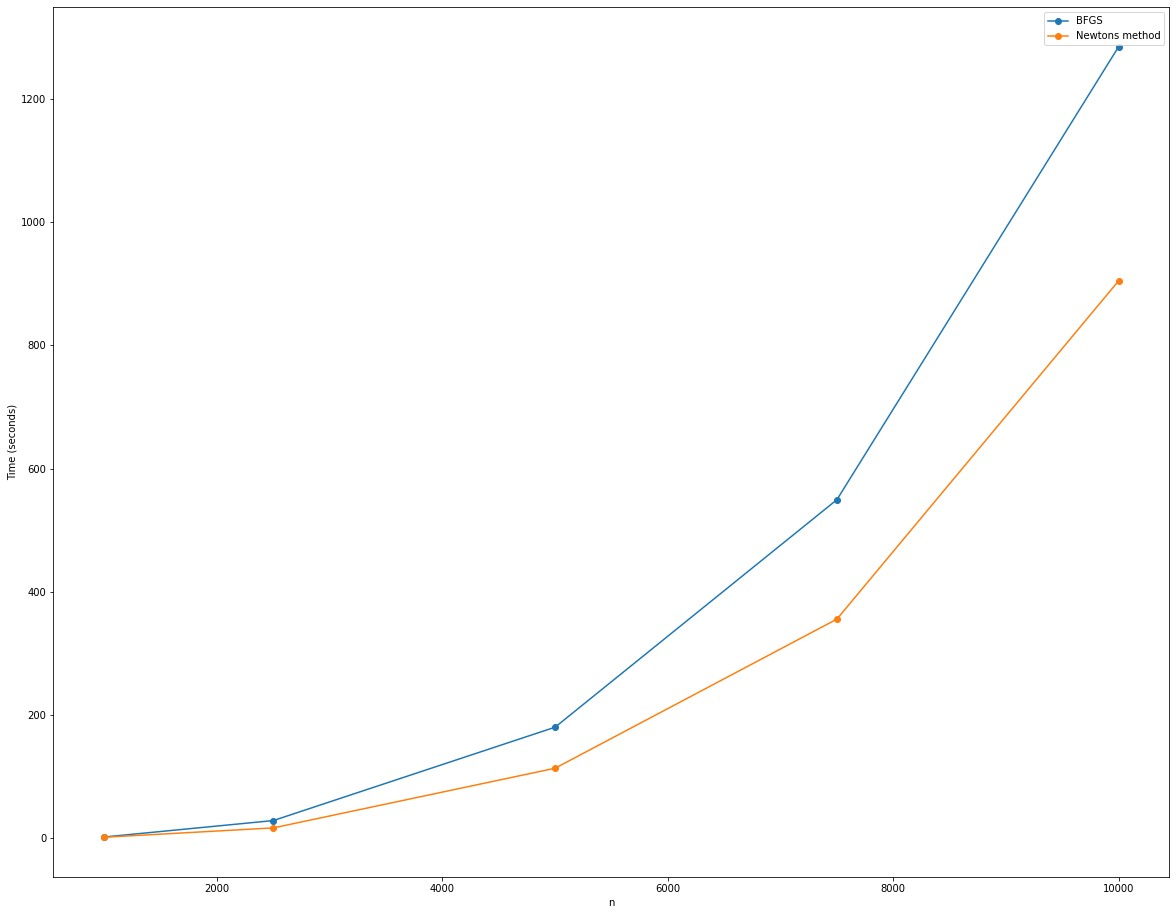

In [ ]:
plt.figure(figsize = (20,16))
plt.plot(nlist,nt,label = 'BFGS',marker='o')
plt.plot(nlist,nt2,label = 'Newtons method',marker='o')
plt.legend()
plt.xlabel('n')
plt.ylabel('Time (seconds)')
plt.show()

For n = 1000 and n=2500 , the time taken by BFGS and newtons method are quite close together. But for larger n, newtons method takes much less time. In fact, the difference between time taken for both methods is increasing as n increases. From the graph, it looks like the ratio of time taken by the two methods may be a constant

In [ ]:
print('Ratio of time taken by both methods as n increases')
[nt[i]/nt2[i] for i in range(5)]

Ratio in time taken fr both methods as n increases


[1.2623393489191408,
 1.7047644713349475,
 1.585607590519755,
 1.5448108080094134,
 1.4198787857195436]

We do observe that the ratio of time taken is in the range [1.4,1.6] for n >= 5000, and even for smaller n, the ratio is not far from this range.

In [ ]:
print('Difference in time taken fr both methods as n increases')
[nt[i]-nt2[i] for i in range(5)]

Difference in time taken fr both methods as n increases


[0.44584409199978836,
 11.89925862599921,
 66.59312456499993,
 193.78755387899946,
 379.9344429470002]

for n = 2500 onwards, we observe that, as n doubles, the difference in time taken increases approximately 6 times. 

In both methods, minimizers were accurate to at least 9 decimal places.